In [14]:
from vampyr import vampyr3d as vp
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

# initialize classes and functions used in the notebook

In [15]:
class Cavity(object):
    def __init__(self, cav_coords, radii, width):
        self.r_list = cav_coords # list of cavity centers. Normally, but not always, nucleus coordinates. 
        self.R_list = radii  # list of cavity radii. Normally, but not always, nucleus radii.
        self.sigma = width  # width of the cavity boundary
   

    def __call__(self,  r):
        """
        r is a list of floats of length 3, can be a numpy array as well
        """
        r_vec = np.array(r)
        C = 1.0
        for i, r_i in enumerate(self.r_list):
            r_vec_i = np.array(r_i)
            s_i = np.linalg.norm(r_vec_i - r_vec) - self.R_list[i]
            O_i = (1.0/2.0)*(1 + erf(s_i/self.sigma))
            C_i = 1 - O_i
            C *= 1 - C_i
        C = 1.0 - C
        return C

    
class lin_permittivity():
    def __init__(self, cavity, e_0=1.0, e_inf=2.0):
        
        self.C = cavity
        self.eps_0 = e_0 # permittivity of free space
        self.eps_inf = e_inf # permittivity of solvent
    
    
    def __call__(self, r):
        C_eval = self.C(r)
        permittivity = C_eval*(self.eps_0 - self.eps_inf) + self.eps_inf
    
        return permittivity


class exp_permittivity():
    def __init__(self, cavity, e_0=1.0, e_inf=2.0):
        
        self.C = cavity
        self.eps_0 = e_0 # permittivity of free space
        self.eps_inf = e_inf # permittivity of solvent
    
    
    def __call__(self, r):
        C_eval = self.C(r)
        permittivity = self.eps_0*np.exp((np.log((self.eps_inf/self.eps_0)))*(1.0 - C_eval))
    
        return permittivity

# Analytic nuclear potential
def f_nuc(r):
    R = np.sqrt(r[0]*r[0] + r[1]*r[1] + r[2]*r[2])
    return -1.0 / R

# Analytic guess for solution
def f_phi(r):
    
    R = np.sqrt(r[0]*r[0] + r[1]*r[1] + r[2]*r[2])
    return np.exp(-R*R)

def dot (A, B):
    out_vec = []
    for A_i, B_i in zip(A, B):
        out_vec.append(A_i*B_i)
    out_tree = vp.sum(out_vec)
    return out_tree

In [16]:
r_x = np.linspace(-10.0, 10.0, 1000) # create an evenly spaced set of points between -0.99 and 0.99
r_y = np.zeros(1000)
r_z = np.zeros(1000)
r = [r_x, r_y, r_z]

# initialize static functions

In [5]:
# Global parameters
k = 7                        # Polynomial order
L = [-20,20]                 # Simulation box size
epsilon = 1.0e-5             # Relative precision

# Define MRA and multiwavelet projector
MRA = vp.MultiResolutionAnalysis(order=k, box=L)
P_eps = vp.ScalingProjector(mra=MRA, prec=epsilon)
D_abgv = vp.ABGVDerivative(mra=MRA, a=0.0, b=0.0)
Poissop = vp.PoissonOperator(mra=MRA, prec=epsilon)

coords = [[0.0000000000,    0.0000000000,    0.000000000]] #centered in 
radii = [2.0598013276]  
width = 0.2

C = Cavity(coords, radii, width)
lin_perm = lin_permittivity(C, e_0=1.0, e_inf=80.0)
exp_perm = exp_permittivity(C, e_0=1.0, e_inf=80.0)

lin_perm_tree = P_eps(lin_perm)
exp_perm_tree = P_eps(exp_perm)

grad_perm =vp.gradient(oper=D_abgv, inp=lin_perm_tree)
# nuclear density and total molecular density to compute the vacuum potential
alpha = 10000
beta = (alpha / np.pi)**(3.0/2.0)
nuc_dens = P_eps(vp.GaussFunc(coef=beta*1.0, exp=alpha))

# solve the SCF

In [6]:
# Project analytic nuclear potential
V_nuc = P_eps(f_nuc)

# Initial guess for energy and orbital
E_n = -0.5
phi_n = P_eps(f_phi)
phi_n.normalize()
phi_n *= -1.0


## Here is the zeroth iteration of the reaction potential solver


rho =  phi_n**2 + nuc_dens
U_vac = Poissop(rho)

#construct gamma_0

grad_U_vac = vp.gradient(oper=D_abgv, inp=U_vac)

dot_tree = dot(grad_perm, grad_U_vac)
gamma_n = (1/(4*np.pi))*(lin_perm_tree**(-1.0))*dot_tree # zero-th gamma

#construct rho_eff
rho_eff = rho*(lin_perm_tree**(-1.0))
poiss_tree = rho_eff 
poiss_tree += gamma_n

#solve the poisson equation for the zeroth order potential
U_n = Poissop(poiss_tree) #zero-th  total potential

# extract the reaction potential for convergence criteria
U_r_n = U_n
U_r_n -= U_vac

diff = U_r_n.norm()  # this is U_r_n - U_r_nm1, but since this started as zero we should just not think about it too much
diff

0.9552728548095809

## Minimization loop

In [7]:
def SCRF(update):
    global U_n
    global U_r_n
    global k
    global axes
    global diff
    j = 0
    print("Running SCRF")
    while((j < 20) and (diff > update)) :   #set a precision threshold
        # construct new gamma from U_n and lin_perm_tree (which is already differentiated)'
        grad_U_nm1 = vp.gradient(oper=D_abgv , inp=U_n) # take gradient from previous iteration

        dot_tree = dot(grad_perm, grad_U_nm1)

        gamma_n = (1/(4*np.pi))*(lin_perm_tree**(-1.0))*dot_tree

        poiss_tree = rho_eff + gamma_n

        # solve poisson equation
        U_n = Poissop(poiss_tree)

        # extract reaction potential for convergence check
        diff_U_r_n = (U_n - U_vac) - U_r_n
        diff = diff_U_r_n.norm()
        U_r_n += diff_U_r_n
        E_r_n = vp.dot(U_r_n, phi_n)
        U_r_plt = [U_r_n([x, 0.0, 0.0]) for x in r_x]
        U_plt = [U_n([x, 0.0, 0.0]) for x in r_x]
        axes[0][1].plot(r_x, U_r_plt, label="U_r_n "+str(k))
        axes[1][1].plot(r_x, U_plt, label="U_n "+str(k))
        axes[0][1].legend()
        axes[1][1].legend()
        print("micro-iteration: {}   Reaction-Energy: {}  Update: {}".format(j, E_r_n, diff))
        j += 1
        k +=1

iteration: 0   Energy: -0.38550553001714716   Norm: 1.0400344496444682   Update: 0.374733691034121
Running SCRF
micro-iteration: 0   Reaction-Energy: 0.17826947714245744  Update: 0.16656974109824121
iteration: 1   Energy: -0.48266778513613073   Norm: 1.2453792113394713   Update: 0.3412378600941955
iteration: 2   Energy: -0.51982240157834   Norm: 1.067741519747627   Update: 0.08452364644300928
Running SCRF
micro-iteration: 0   Reaction-Energy: 0.5337706808711298  Update: 0.9643189803427454
micro-iteration: 1   Reaction-Energy: 0.4842076883230093  Update: 0.16609753190725415
micro-iteration: 2   Reaction-Energy: 0.4898803403936634  Update: 0.019203841958117446
iteration: 3   Energy: -0.5460128803031292   Norm: 1.0352589080432457   Update: 0.038169161987657865
iteration: 4   Energy: -0.546892751790041   Norm: 0.999376414950151   Update: 0.0034913079706232787
Running SCRF
micro-iteration: 0   Reaction-Energy: 0.492560104910407  Update: 0.001669114796484102
iteration: 5   Energy: -0.5468578

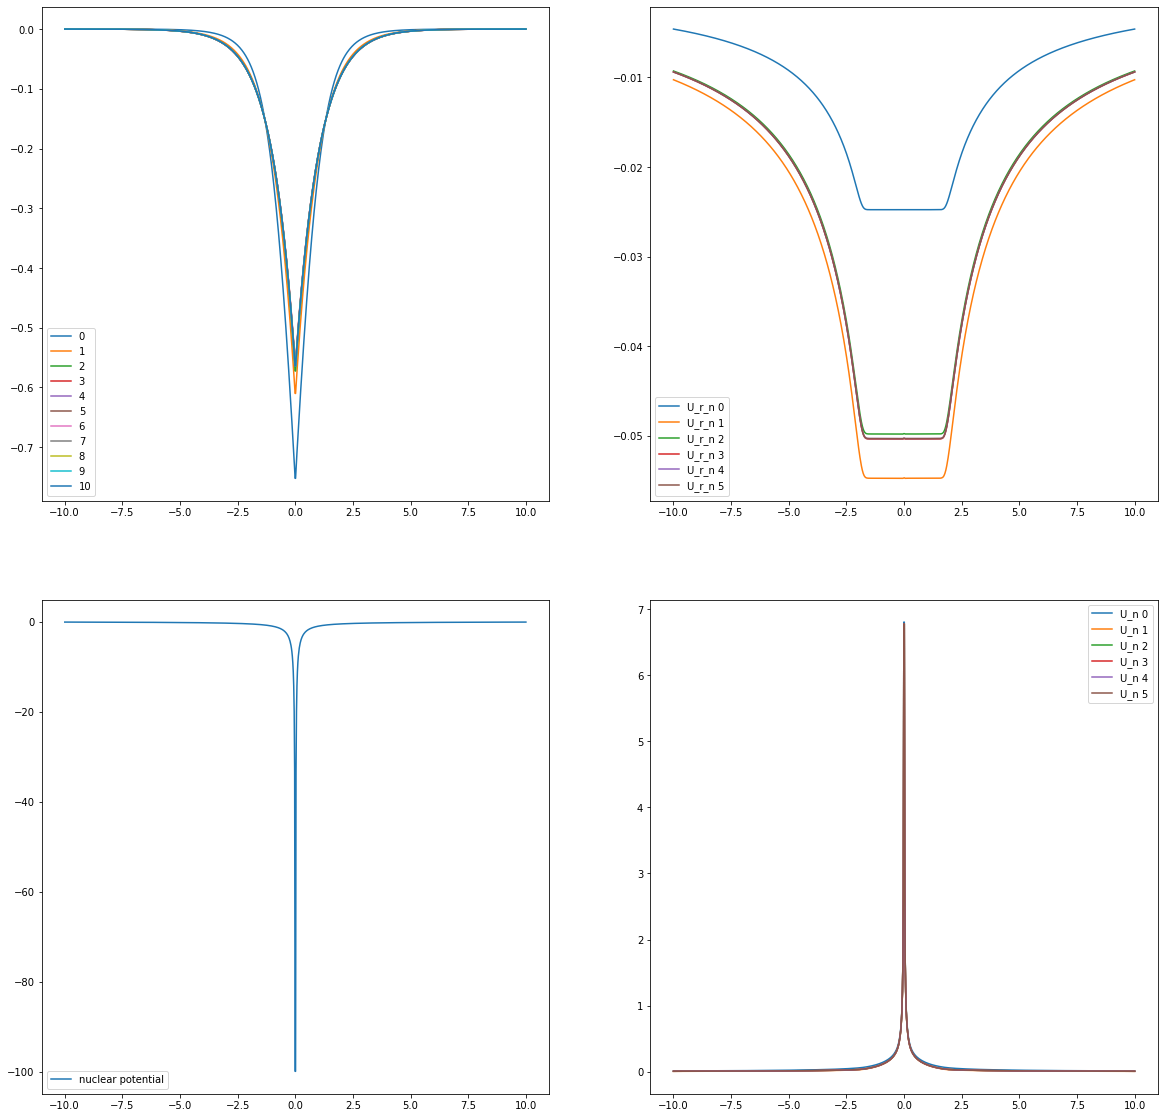

In [8]:
thrs = 1.0e-4
update = 1.0
i = 0
k = 0
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[20, 20])
while (update > thrs and i < 100):
    if (i != 0 and (diff > update)):
        SCRF(update)    
    # Prepare Helmholtz operator
    mu = np.sqrt(-2*E_n)
    H = vp.HelmholtzOperator(mra=MRA, exp=mu, prec=epsilon)
    
    # Apply Helmholtz operator
    Vphi = (V_nuc + U_r_n)* phi_n #add the solvent reaction potential to the equation
    phi_np1 = -2*H(Vphi)
    norm = phi_np1.norm()
    
    # Compute orbital and energy updates
    dPhi_n = phi_np1 - phi_n
    dE_n = vp.dot(Vphi, dPhi_n)/phi_np1.squaredNorm()
    update = dPhi_n.norm()
    
    # Prepare for next iteration
    E_n += dE_n
    phi_n += dPhi_n
    phi_n.normalize()
    phi_n.crop(epsilon)
    E_r_n = vp.dot(U_r_n, phi_n)

    rho =  phi_n**2 +  nuc_dens

    phi_n_plt = [phi_n([x, 0.0, 0.0]) for x in r_x]
    axes[0][0].plot(r_x, phi_n_plt, label=str(i))
    axes[0][0].legend()
    
    print("iteration: {}   Energy: {}   Norm: {}   Update: {}".format(i, E_n, norm, update))
    i += 1
V_nuc_eval = [V_nuc([x, 0.0, 0.0]) for x in r_x]
axes[1][0].plot(r_x, V_nuc_eval, label="nuclear potential")
axes[1][0].legend()
plt.legend()
plt.show()

# water single iteration

In [ ]:
wat_coords = [[0.0000000000,    0.0000000000,    0.2199848921],
          [0.0000000000,    1.4389053978,   -0.879941458],
          [0.0000000000,   -1.4389053978,   -0.879941458]] #centered in 
wat_radii = [2.87236857024075, 2.0598013276, 2.0598013276]  
width = 0.2

C_wat = Cavity(wat_coords, wat_radii, width)
wat_lin_perm = lin_permittivity(C, e_0=1.0, e_inf=80.0)
wat_exp_perm = exp_permittivity(C, e_0=1.0, e_inf=80.0)

wat_lin_perm_tree = P_eps(wat_lin_perm)
wat_exp_perm_tree = P_eps(wat_exp_perm)

wat_grad_perm =vp.gradient(oper=D_abgv, inp=wat_lin_perm_tree)


alpha = 10000
beta = (alpha / np.pi)**(3.0/2.0)
H_1 = P_eps(vp.GaussFunc(coef=beta*1.0, exp=alpha, pos=[0.0000000000,    1.4389053978,   -0.879941458]))
H_2 = P_eps(vp.GaussFunc(coef=beta*1.0, exp=alpha, pos=[0.0000000000,    -1.4389053978,   -0.879941458]))
O_1 = P_eps(vp.GaussFunc(coef=beta*8.0, exp=alpha, pos=[0.0000000000,    0.0000000000,    0.2199848921]))
wat_nuc_dens = H_1 + H_2 + O_1

phi_H_1 = P_eps(vp.GaussFunc(coef=1.0, exp=1.0, pos=[0.0000000000,    1.4389053978,   -0.879941458]))
phi_H_1.normalize()
phi_H_1 *= -1.0
phi_H_2 = P_eps(vp.GaussFunc(coef=1.0, exp=1.0, pos=[0.0000000000,    1.4389053978,   -0.879941458]))
phi_H_2.normalize()
phi_H_2 *= -1.0
phi_O_1 = P_eps(vp.GaussFunc(coef=1.0, exp=1.0, pos=[0.0000000000,    0.0000000000,    0.2199848921]))
phi_O_1.normalize()
phi_O_1 *= -8.0